In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

### Loading Datasets :

In [2]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [3]:
print('train : ', train.shape, '\n', 'test : ', test.shape)

train :  (1460, 81) 
 test :  (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.describe

<bound method NDFrame.describe of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour 

In [6]:
# dropping 'id' column as its of no use

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [7]:
# Removing target variables from train data and storing it separately

y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

### Data Analysis :

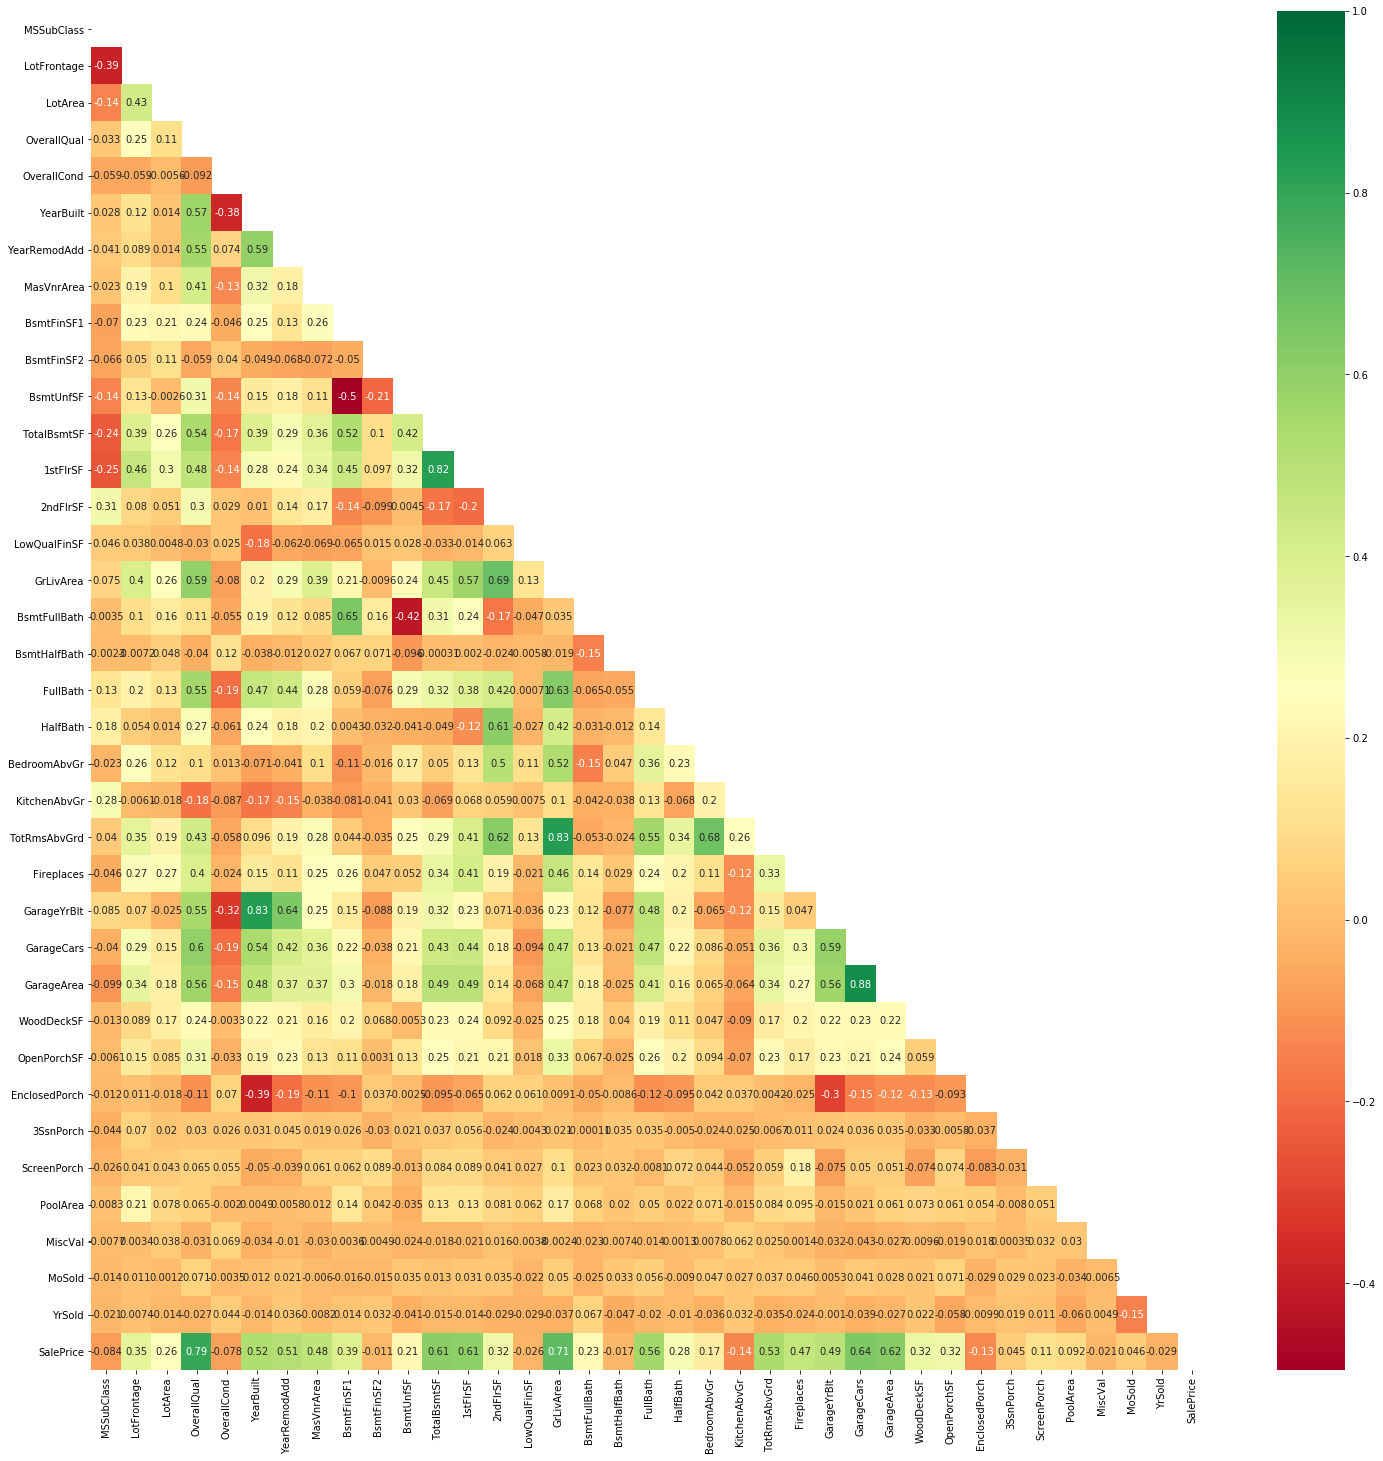

In [8]:
mask = np.zeros(train.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(25,25))
p=sns.heatmap(train.corr(), annot=True,cmap ='RdYlGn', mask=mask)

In [9]:
# merging train & test features before editing to prevent doing same thing twice

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2919, 79)


### Missing Data :

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageQual,GarageYrBlt,GarageFinish,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MasVnrArea,MSZoning,BsmtHalfBath,Utilities,Functional,BsmtFullBath,BsmtFinSF2,BsmtFinSF1,Exterior2nd,BsmtUnfSF,TotalBsmtSF,Exterior1st,SaleType,Electrical,KitchenQual,GarageArea,GarageCars
Total,2909.000000,2814.000000,2721.000000,2348.000000,1420.000000,486.000000,159.000000,159.000000,159.000000,159.000000,157.000000,82.000000,82.000000,81.000000,80.000000,79.000000,24.000000,23.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Percent,99.657417,96.402878,93.216855,80.438506,48.646797,16.649538,5.447071,5.447071,5.447071,5.447071,5.378554,2.809181,2.809181,2.774923,2.740665,2.706406,0.822199,0.787941,0.137033,0.068517,0.068517,0.068517,0.068517,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258,0.034258


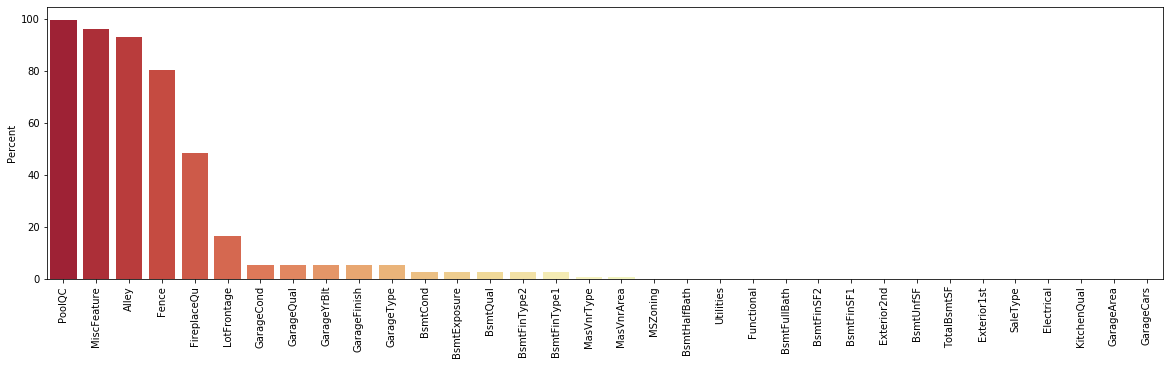

In [12]:
def missing_percentage(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    total = missing [missing != 0]
    percent = (missing / len(df) * 100)[(missing / len(df) * 100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_data = missing_percentage(features)

# Plotting
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing_data.index, y='Percent', data=missing_data, palette='RdYlGn')
plt.xticks(rotation=90)

display(missing_data.T.style.background_gradient(cmap='RdYlGn', axis=1))

### Filling Missing data :
1. Replace Nan in non-numeric columns with "None"
2. Replace Nan in numeric columns with 0
3. In rest replace with the most common value in column (Mode)

In [13]:
# List of columns where NaN's mean none.

none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
# List of columns where NaN's mean 0.

zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of columns where data is actually missing gonna replaced with mode.

freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]


# Filling the list of columns above:

for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [14]:
# Filling MSZoning according to MSSubClass

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

In [15]:
# Filling LotFrontage according to Neighborhood

features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))



In [16]:
# Features which numerical on data but should be treated as category.

features['MSSubClass'] = features['MSSubClass'].astype(str)

features['YrSold'] = features['YrSold'].astype(str)

features['MoSold'] = features['MoSold'].astype(str)

### Feature Engineering :

In [17]:
# Transforming rare values(less than 10 occurances) into one group

others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

C:\Users\Abhijeet\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


### Catagorical Data :

In [18]:
# Function to make subplots of boxplots  

def srt_box(y, df):
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

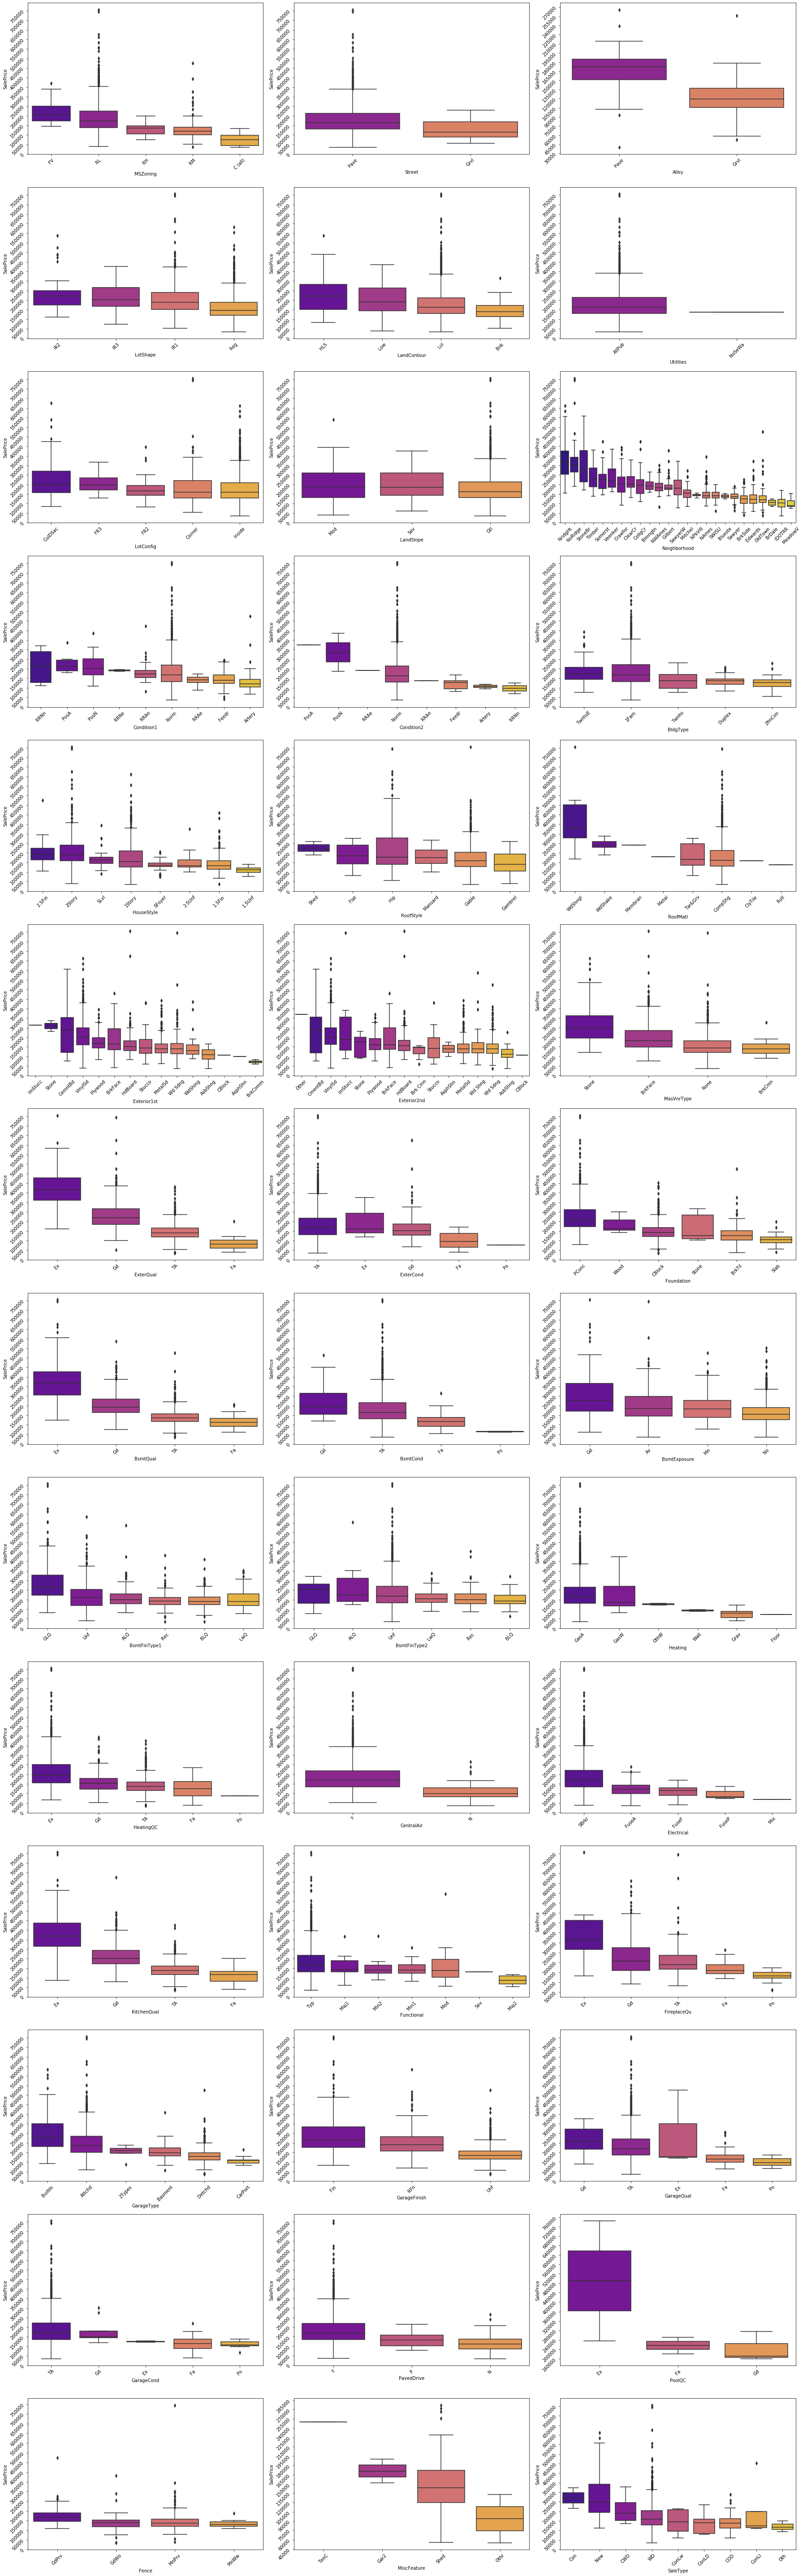

In [19]:
# Displaying sale prices vs. categorical values

srt_box('SalePrice', train)

In [20]:
# Converting Catagorical features to Numeric ones

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}
features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype('int')

ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')

bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')

bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,

    'GLQ': 6
}
features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')

heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')

features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')



### Numeric Data :

In [22]:
# Plotting numerical features with polynomial order to detect outliers

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='blue',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

C:\Users\Abhijeet\anaconda3\lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)
C:\Users\Abhijeet\anaconda3\lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  yhat = reg_func(x, y)


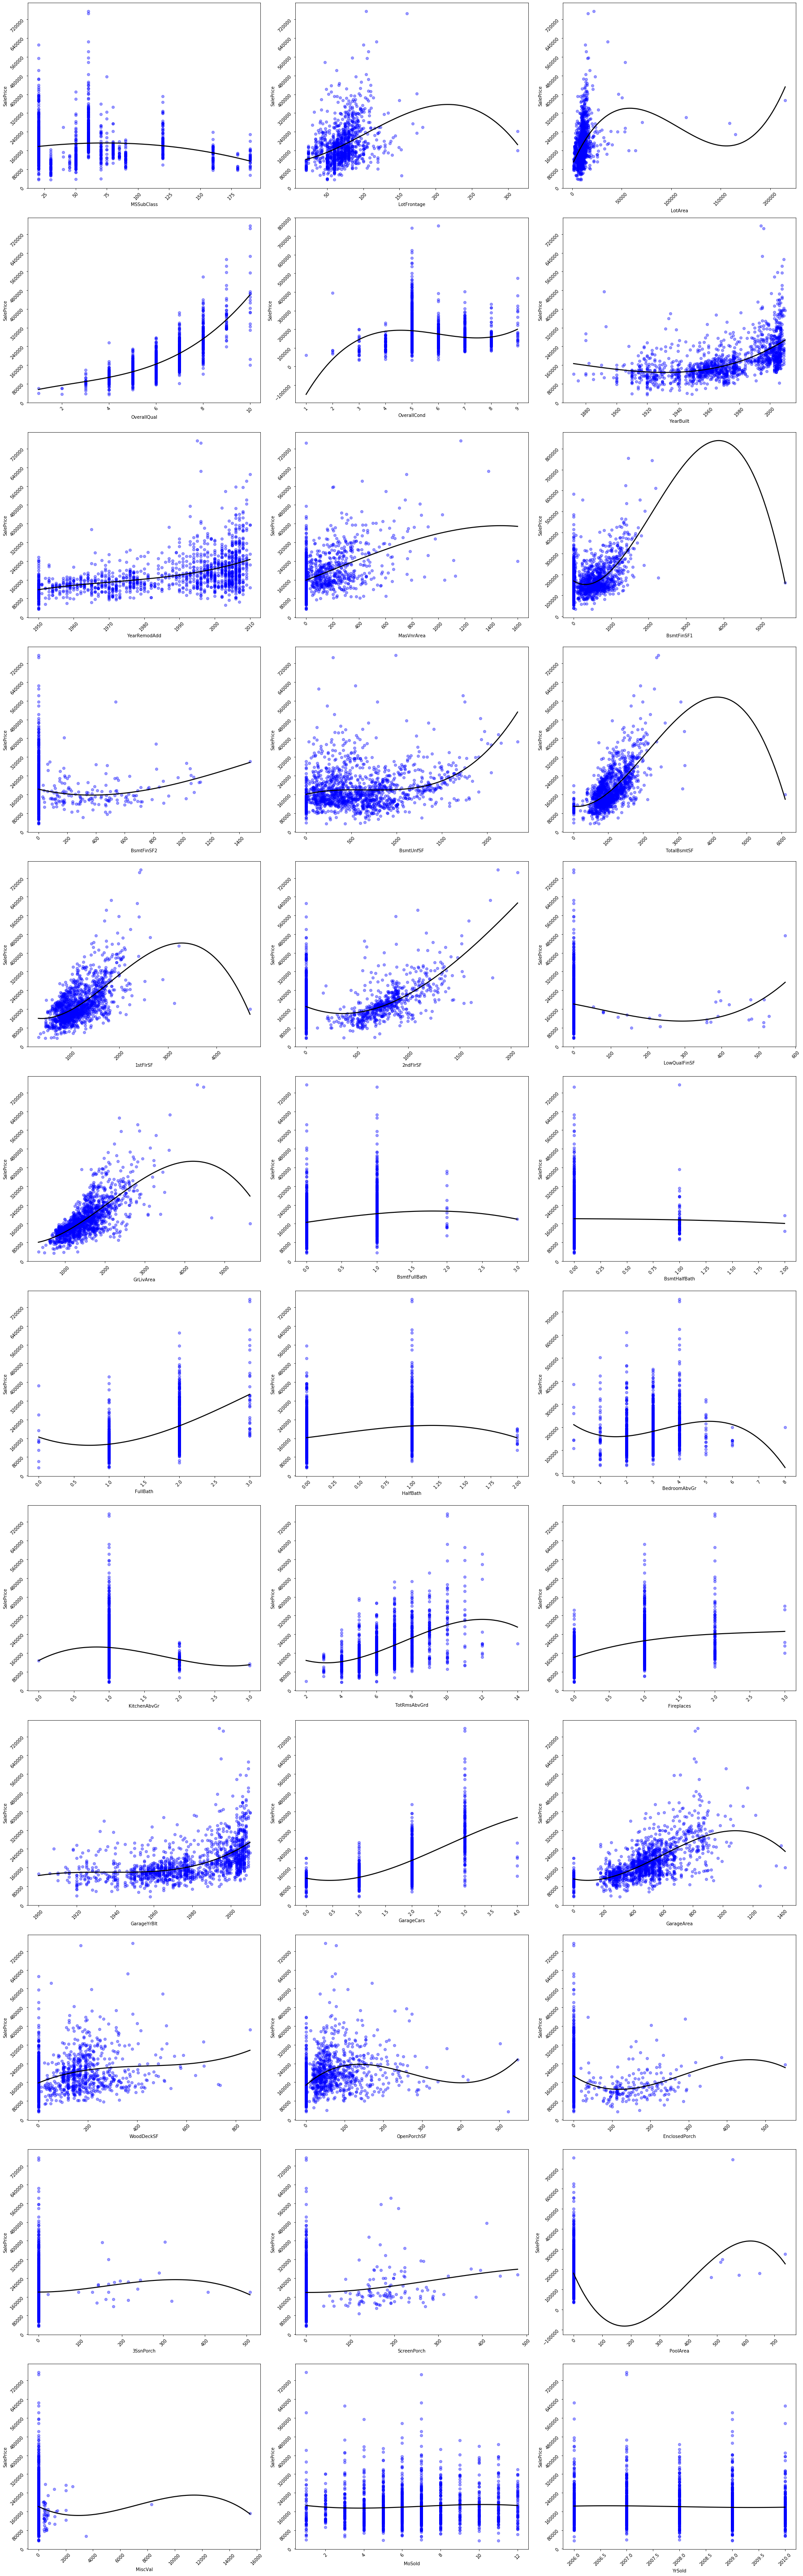

In [23]:
srt_reg('SalePrice', train)

### Outliers :

In [24]:
# Dropping outliers manually

features = features.join(y)
features = features.drop(features[(features['OverallQual'] < 5) & (features['SalePrice'] > 200000)].index)
features = features.drop(features[(features['GrLivArea'] > 4000) & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['GarageArea'] > 1200) & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['TotalBsmtSF'] > 3000) & (features['SalePrice'] > 320000)].index)
features = features.drop(features[(features['1stFlrSF'] < 3000) & (features['SalePrice'] > 600000)].index)
features = features.drop(features[(features['1stFlrSF'] > 3000) & (features['SalePrice'] < 200000)].index)

y = features['SalePrice']
y.dropna(inplace=True)
features.drop(columns='SalePrice', inplace=True)

### New Features :

In [25]:
# Creating new features  based on previous observations

features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] + features['1stFlrSF'] + features['2ndFlrSF'])
features['TotalBathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))
features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] + features['EnclosedPorch'] + features['ScreenPorch'] + features['WoodDeckSF'])
features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

# Merging quality and conditions

features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'] + features['BsmtFinType1'] + features['BsmtFinType2'])
features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
features['TotalQual'] = features['OverallQual'] + features['TotalExtQual'] + features['TotalBsmQual'] + features['TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

# Creating new features by using new quality indicators

features['QualGr'] = features['TotalQual'] * features['GrLivArea']
features['QualBsm'] = features['TotalBsmQual'] * (features['BsmtFinSF1'] + features['BsmtFinSF2'])
features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
features['QlLivArea'] = (features['GrLivArea'] - features['LowQualFinSF']) * (features['TotalQual'])
features['QualSFNg'] = features['QualGr'] * features['Neighborhood']

### Checking the newly created features :

In [26]:
# Checking the effects of newly creater features on sale price

def srt_reg(feature):
    merged = features.join(y)
    fig, axes = plt.subplots(5, 3, figsize=(25, 40))
    axes = axes.flatten()

    new_features = [
        'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'YearBlRm',
        'TotalExtQual', 'TotalBsmQual', 'TotalGrgQual', 'TotalQual', 'QualGr',
        'QualBsm', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea', 'QualSFNg'
    ]

    for i, j in zip(new_features, axes):

        sns.regplot(x=i,
                    y=feature,
                    data=merged,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

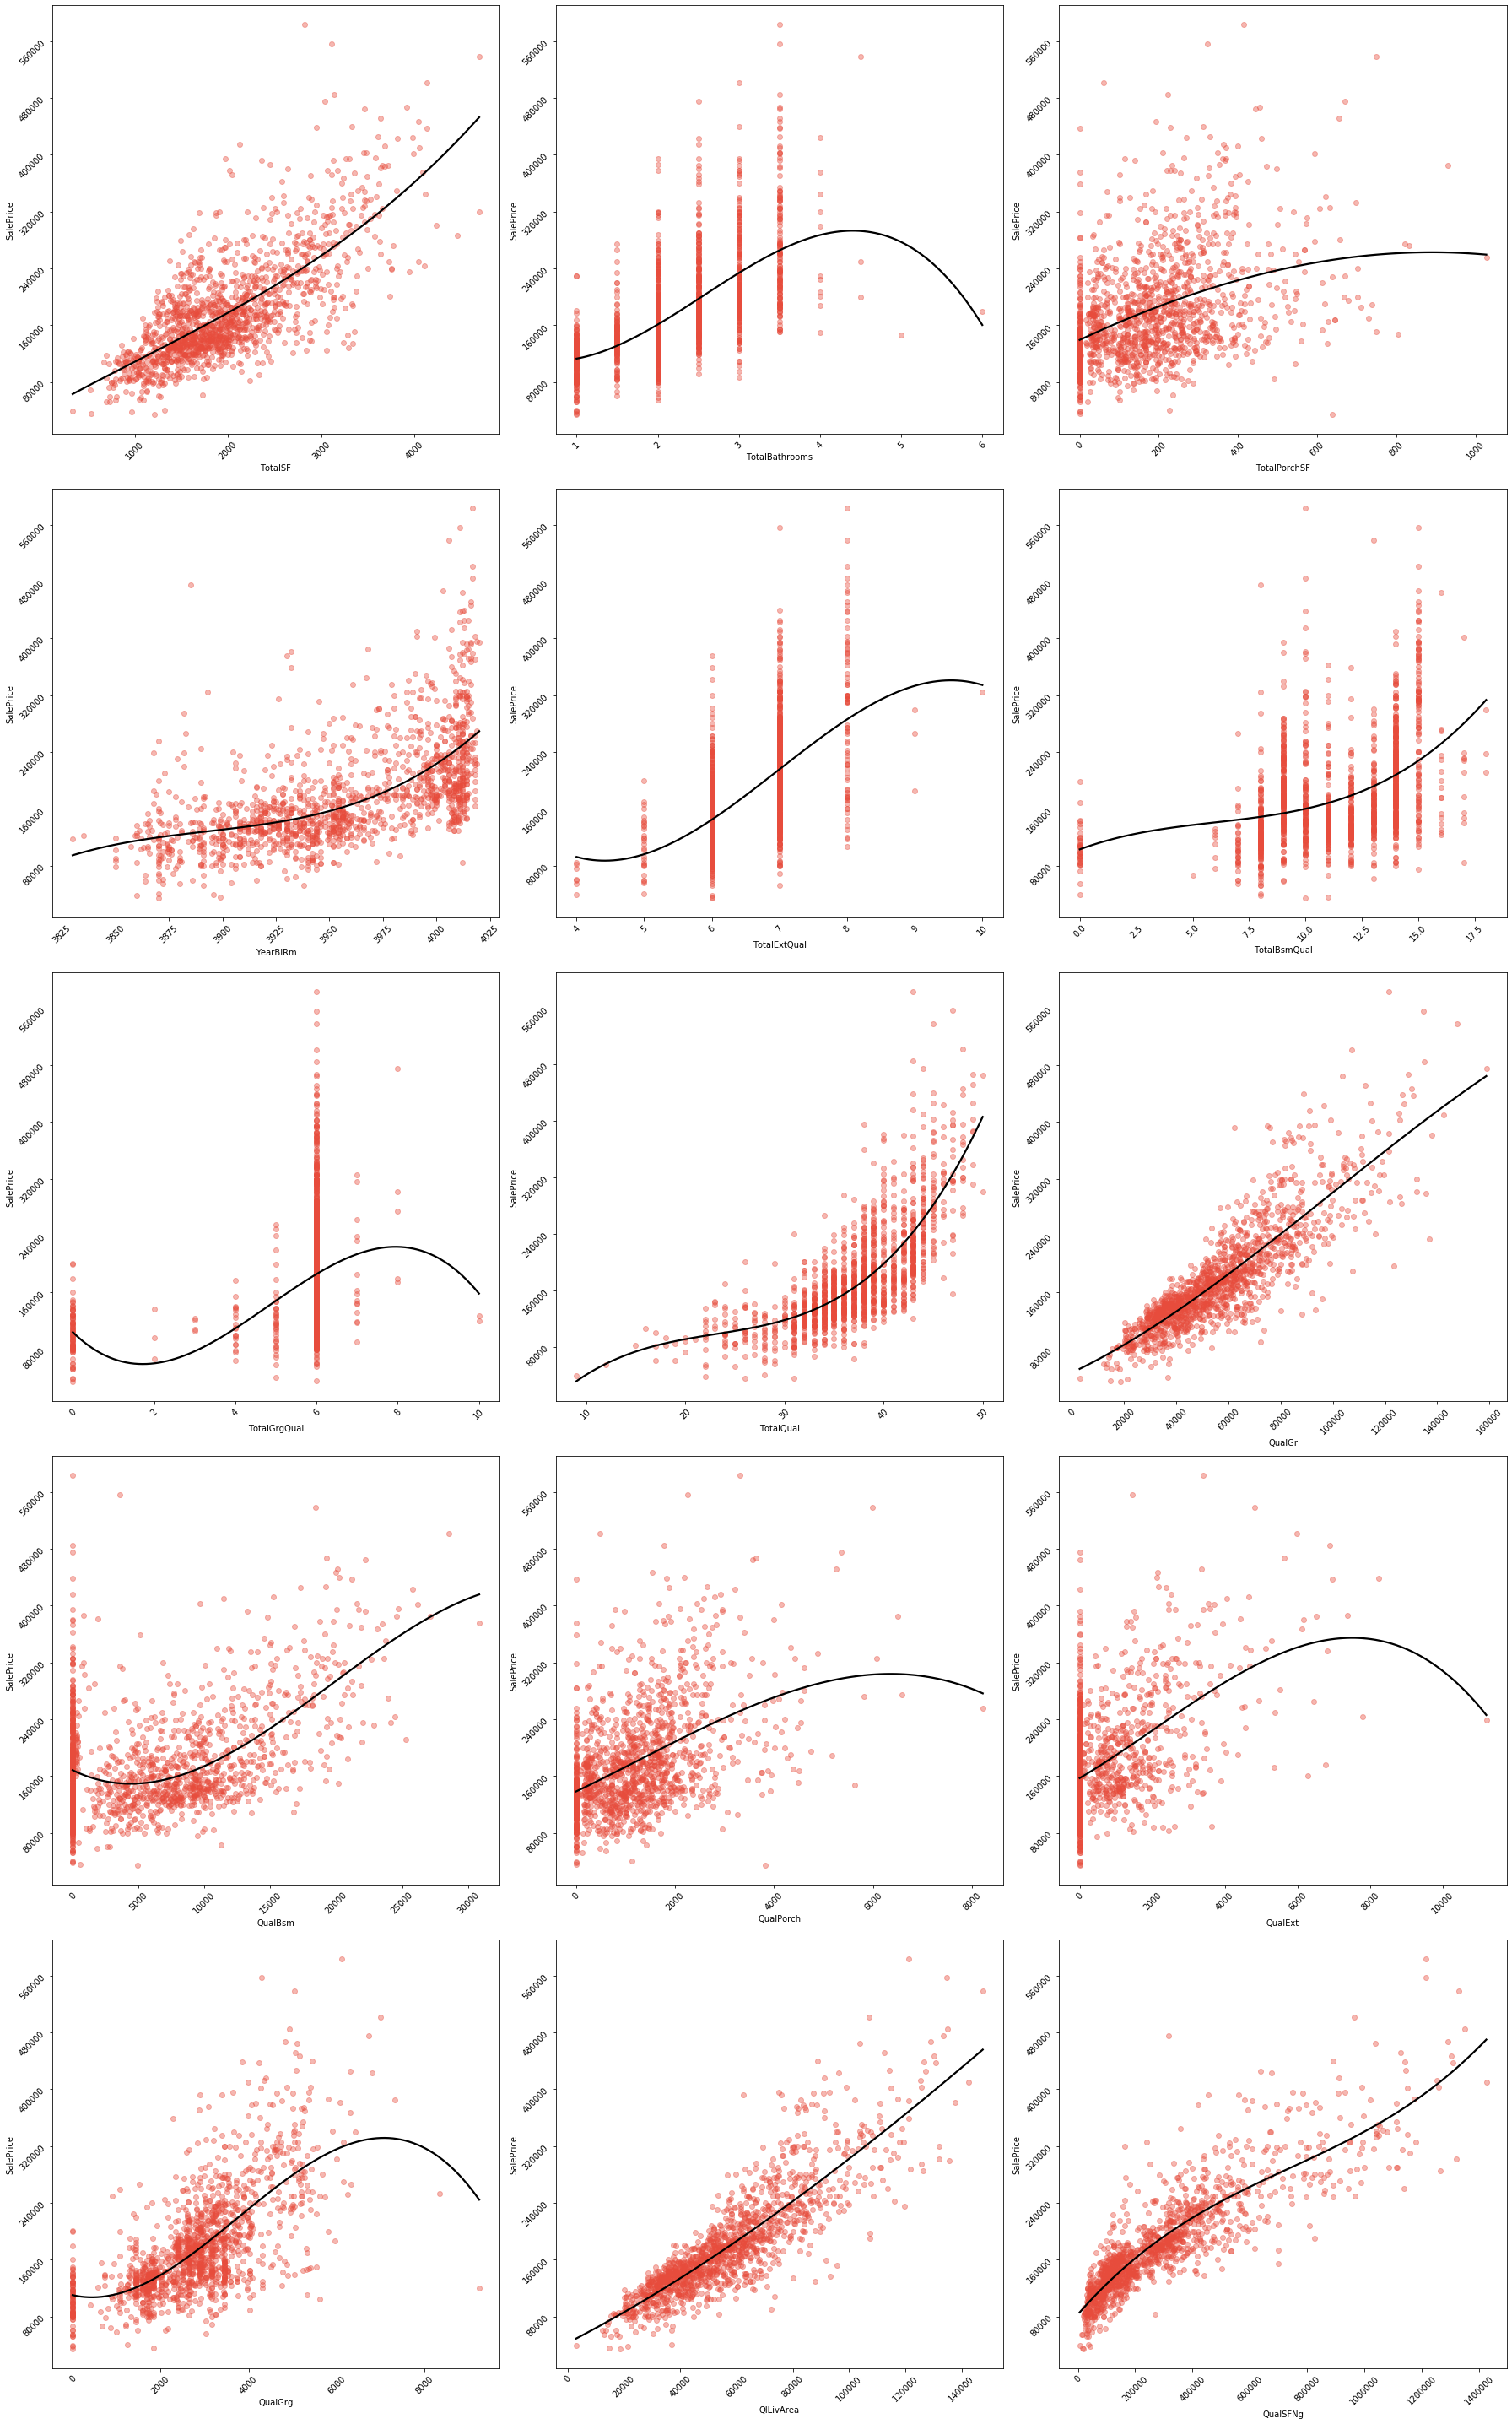

In [27]:
srt_reg('SalePrice')

In [28]:
# Creating some new simple features

features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

features['HasGarage'] = features['QualGrg'].apply(lambda x: 1 if x > 0 else 0)

features['HasBsmt'] = features['QualBsm'].apply(lambda x: 1 if x > 0 else 0)

features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

features['HasPorch'] = features['QualPorch'].apply(lambda x: 1 if x > 0 else 0)

### Transformations :

In [31]:
# List skewed features and then apply boxcox transformation with boxcox_normmax 

possible_skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]

In [32]:
# Finding skewness of the numerical features

skew_features = np.abs(features[possible_skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [33]:
# Drop unnecessary features :

to_drop = [
    'Utilities',
    'PoolQC',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features

features.drop(columns=to_drop, inplace=True)

In [34]:
# Getting dummy variables for categorical data

features = pd.get_dummies(data=features)


### Final check :

In [35]:
print('Number of missing values: ',features.isna().sum().sum())

Number of missing values:  0


In [36]:
features.shape

(2908, 226)

In [37]:
features.sample(5)

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,...,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
562,18.033693,15.267634,2,5,6,1940,1969,0.00000,3,3,...,0,0,0,1,0,0,0,0,1,0
1120,17.296297,14.046113,1,6,5,1920,1950,0.00000,3,3,...,0,0,0,1,0,0,0,0,1,0
729,15.955429,13.411131,1,4,5,1925,1950,0.00000,3,3,...,0,0,0,1,0,0,0,0,1,0
20,24.281206,15.320325,10,8,5,2005,2006,26.58386,3,3,...,0,1,0,0,0,0,0,0,0,1
845,19.626927,15.703373,3,5,5,1975,1981,0.00000,3,3,...,0,0,0,1,0,0,0,0,1,0


In [38]:
features.describe()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,...,SaleType_ConLD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,18.932142,14.236978,4.455640,6.081843,5.566713,1971.252751,1984.227992,8.080447,3.085282,2.918157,...,0.008597,0.081155,0.009972,0.866231,0.064993,0.004127,0.008253,0.015818,0.823590,0.083219
std,3.698921,1.155737,2.457431,1.397639,1.114074,30.296319,20.899483,11.027780,0.372262,0.576014,...,0.092336,0.273121,0.099380,0.340462,0.246556,0.064117,0.090486,0.124794,0.381234,0.276260
min,8.809473,10.151044,1.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.482488,13.809916,3.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,19.280169,14.351060,4.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,20.976651,14.815543,5.000000,7.000000,6.000000,2001.000000,2004.000000,17.877327,3.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,48.749455,22.753416,10.000000,10.000000,9.000000,2010.000000,2010.000000,50.647626,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
# Separating train and test feature sets

train = features.iloc[:len(y), :]
test = features.iloc[len(train):, :]

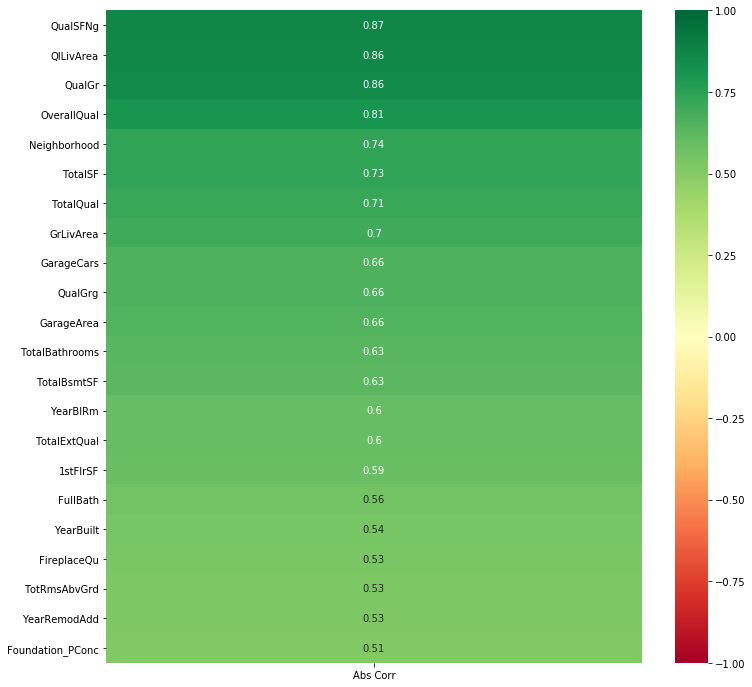

In [40]:
correlations = train.join(y).corrwith(train.join(y)['SalePrice']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='RdYlGn', annot=True, vmin=-1, vmax=1, ax=ax);

In [42]:
def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    # creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature], hist=True, kde=True, fit=norm, ax=ax1, color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Probability Plot')
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])), plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)

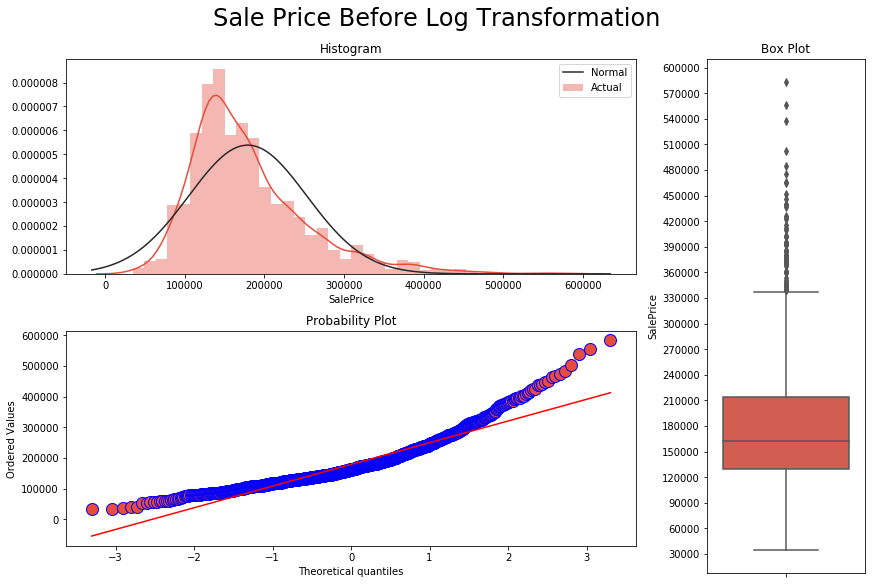

In [43]:
# Checking target variable

plot_dist3(train.join(y), 'SalePrice', 'Sale Price Before Log Transformation')

In [44]:
# Setting model data

X = train
X_test = test
y = np.log1p(y)

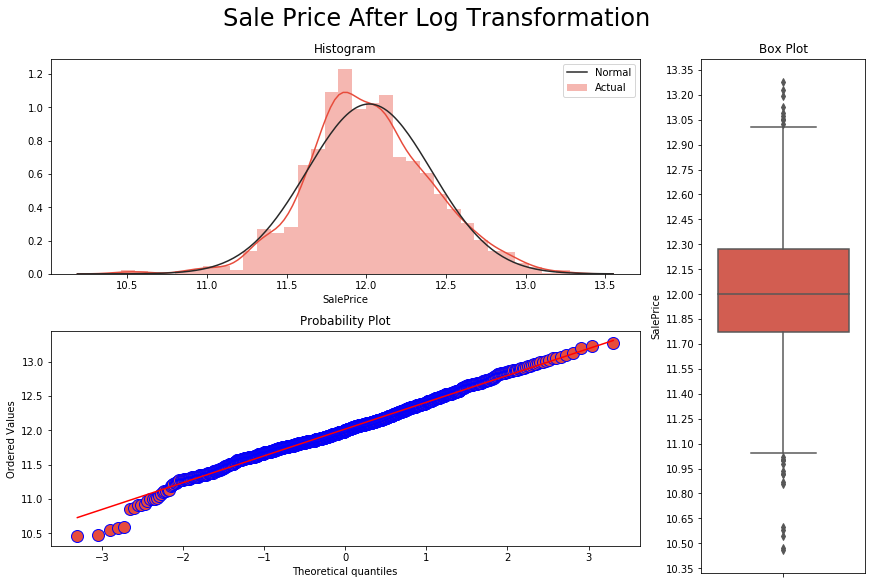

In [46]:
plot_dist3(train.join(y), 'SalePrice', 'Sale Price After Log Transformation')